In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, Model
import pickle
import matplotlib.pyplot as plt
import os
import db_connection as db



In [17]:
# ---------- 1. Data Loading & Preprocessing ----------
# Load cleaned flight data
df = db.read_db("flights_cleaned")
df.columns.tolist()
df.describe()


,latitude,longitude,gps_altitude_m,distance_m,speed_km/s,climb_m,climb_m(delta),climb_rate_m/s,glide_ratio,bearing,delta_bearing,elapsed_time,delta_time,temp,pressure,humidity,dew_point,wind_speed,wind_deg
count,1.516903e+06,1.516903e+06,1.516903e+06,1.516903e+06,1.516903e+06,1.516903e+06,1.516903e+06,1.516903e+06,1.516903e+06,1.516903e+06,1.516903e+06,1.516903e+06,1516903.0,1.516903e+06,1.516903e+06,1.516903e+06,1.516903e+06,1.516903e+06,1.516903e+06
mean,3.845003e+01,3.220131e+01,2.521917e+03,1.386962e+01,4.993064e+01,1.985559e-02,5.416859e-01,1.985559e-02,7.413505e+00,1.452901e+02,9.854460e+00,1.361979e+04,1.0,3.094195e+01,1.007346e+03,2.690490e+01,9.109070e+00,3.256551e+00,2.293494e+02
std,1.107924e+00,2.782908e+00,6.636743e+02,4.409383e+00,1.587378e+01,2.091508e+00,3.568124e+01,2.091508e+00,5.842336e+00,9.045108e+01,1.289737e+01,8.053168e+03,0.0,3.504457e+00,2.388517e+00,7.400793e+00,3.050062e+00,1.382203e+00,1.145345e+02
min,3.650395e+01,2.463248e+01,1.600000e+01,1.422486e+00,5.120948e+00,-6.000000e+00,-1.650000e+02,-6.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.0,1.960000e+01,1.001000e+03,9.000000e+00,-2.230000e+00,0.000000e+00,0.000000e+00
25%,3.741405e+01,3.020254e+01,2.062000e+03,1.098388e+01,3.954197e+01,-1.000000e+00,-2.700000e+01,-1.000000e+00,2.992604e+00,6.900000e+01,2.000000e+00,6.726000e+03,1.0,2.864000e+01,1.006000e+03,2.200000e+01,6.990000e+00,2.270000e+00,1.880000e+02
50%,3.838047e+01,3.234353e+01,2.523000e+03,1.421200e+01,5.116319e+01,0.000000e+00,1.000000e+00,0.000000e+00,6.366651e+00,1.480000e+02,6.000000e+00,1.343800e+04,1.0,3.062000e+01,1.007000e+03,2.700000e+01,9.290000e+00,3.250000e+00,2.620000e+02
75%,3.923862e+01,3.276135e+01,2.972000e+03,1.709671e+01,6.154814e+01,1.000000e+00,2.700000e+01,1.000000e+00,1.131659e+01,2.010000e+02,1.300000e+01,2.012200e+04,1.0,3.313000e+01,1.009000e+03,3.200000e+01,1.123000e+01,4.180000e+00,3.290000e+02
max,4.272443e+01,4.104868e+01,8.500000e+03,2.763880e+01,9.949969e+01,6.000000e+00,1.650000e+02,6.000000e+00,2.761553e+01,3.560000e+02,1.800000e+02,3.646100e+04,1.0,4.111000e+01,1.015000e+03,5.800000e+01,2.225000e+01,8.700000e+00,3.600000e+02


In [18]:
# Separate features and target
feature_cols = [
    'gps_altitude_m', 'distance_m', 'speed_km/s', #'climb_m', 
    'glide_ratio', 'bearing', 'delta_bearing',
    'temp', 'pressure', 'humidity', 'dew_point',
    'wind_speed', 'wind_deg'
]
X_raw = df[feature_cols].values.astype(np.float32)
y_raw = df['climb_rate_m/s'].values.astype(np.float32)

# Train-test split on raw data
split_frac = 0.8
split_idx = int(len(X_raw) * split_frac)
X_train_raw, X_test_raw = X_raw[:split_idx], X_raw[split_idx:]
y_train_raw, y_test_raw = y_raw[:split_idx], y_raw[split_idx:]

# Feature scaling
scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train_scaled = scaler.transform(X_train_raw)
X_test_scaled  = scaler.transform(X_test_raw)

# Persist scaler locally
os.makedirs('models', exist_ok=True)
scaler_path = os.path.join('models', 'scaler.pkl')
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"Scaler saved to {scaler_path}")


Scaler saved to models\scaler.pkl


In [19]:

# ---------- 2. Create tf.data sliding-window datasets ----------
T = 10              # history length
batch_size = 32
train_ds = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=X_train_scaled,
    targets=y_train_raw,
    sequence_length=T,
    sequence_stride=1,
    shuffle=False,
    batch_size=batch_size
)
test_ds = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=X_test_scaled,
    targets=y_test_raw,
    sequence_length=T,
    sequence_stride=1,
    shuffle=False,
    batch_size=batch_size
)


In [20]:

# ---------- 3. Positional Encoding for Transformer ----------
def get_positional_encoding(sequence_length, d_model):
    pos = np.arange(sequence_length)[:, np.newaxis]
    i   = np.arange(d_model)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / d_model)
    angle_rads  = pos * angle_rates
    sines = np.sin(angle_rads[:, 0::2])
    cosines = np.cos(angle_rads[:, 1::2])
    return tf.cast(np.concatenate([sines, cosines], axis=-1), tf.float32)

# Dimensions
n_features = X_raw.shape[1]

def build_lstm_model(seq_len, n_feats):
    inp = layers.Input(shape=(seq_len, n_feats))
    x = layers.LSTM(64)(inp)
    x = layers.Dense(32, activation='relu')(x)
    out = layers.Dense(1)(x)
    return Model(inp, out, name='LSTM')


def build_rnn_model(seq_len, n_feats):
    inp = layers.Input(shape=(seq_len, n_feats))
    x = layers.SimpleRNN(64)(inp)
    x = layers.Dense(32, activation='relu')(x)
    out = layers.Dense(1)(x)
    return Model(inp, out, name='RNN')


def build_cnn_model(seq_len, n_feats):
    inp = layers.Input(shape=(seq_len, n_feats))
    x = layers.Conv1D(32, 3, activation='relu')(inp)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(64, 3, activation='relu')(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(32, activation='relu')(x)
    out = layers.Dense(1)(x)
    return Model(inp, out, name='CNN')


def build_transformer_model(seq_len, n_feats, d_model=64, num_heads=4):
    inp = layers.Input(shape=(seq_len, n_feats))
    x = layers.Dense(d_model)(inp)
    pos_enc = get_positional_encoding(seq_len, d_model)
    x = x + pos_enc
    attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
    x = layers.LayerNormalization(epsilon=1e-6)(x + attn)
    ffn_block = Sequential([
        layers.Dense(d_model*2, activation='relu'),
        layers.Dense(d_model)
    ])
    x = layers.LayerNormalization(epsilon=1e-6)(x + ffn_block(x))
    x = layers.GlobalAveragePooling1D()(x)
    out = layers.Dense(1)(x)
    return Model(inp, out, name='Transformer')

# Map model names to builders
type_map = {
    'LSTM': build_lstm_model,
    'RNN': build_rnn_model,
    'CNN': build_cnn_model,
    'Transformer': build_transformer_model
}


In [21]:

# ---------- 4. Training Loop & Saving ----------
results = {}
for name, builder in type_map.items():
    print(f"\n>>> Training {name} <<<")
    model = builder(T, n_features)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    model.fit(train_ds, validation_data=test_ds, epochs=10, verbose=1)
    # Evaluate
    y_pred = model.predict(test_ds).flatten()
    y_true = np.concatenate([y for _, y in test_ds], axis=0)
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    results[name] = (mae, rmse)
    # Save
    save_path = os.path.join('models', f"{name.lower()}_model.keras")
    model.save(save_path)
    print(f"{name} saved to {save_path}")



>>> Training LSTM <<<
Epoch 1/10
37923/37923 ━━━━━━━━━━━━━━━━━━━━ 141s 4ms/step - loss: 2.1635 - mae: 1.0543 - val_loss: 2.0041 - val_mae: 0.8100
Epoch 2/10
37923/37923 ━━━━━━━━━━━━━━━━━━━━ 144s 4ms/step - loss: 1.1186 - mae: 0.6035 - val_loss: 1.6530 - val_mae: 0.6847
Epoch 3/10
37923/37923 ━━━━━━━━━━━━━━━━━━━━ 145s 4ms/step - loss: 0.9500 - mae: 0.5275 - val_loss: 1.5040 - val_mae: 0.6334
Epoch 4/10
37923/37923 ━━━━━━━━━━━━━━━━━━━━ 143s 4ms/step - loss: 0.8696 - mae: 0.4933 - val_loss: 1.3516 - val_mae: 0.6172
Epoch 5/10
37923/37923 ━━━━━━━━━━━━━━━━━━━━ 144s 4ms/step - loss: 0.8238 - mae: 0.4720 - val_loss: 1.3491 - val_mae: 0.5941
Epoch 6/10
37923/37923 ━━━━━━━━━━━━━━━━━━━━ 140s 4ms/step - loss: 0.7973 - mae: 0.4599 - val_loss: 1.3441 - val_mae: 0.5860
Epoch 7/10
37923/37923 ━━━━━━━━━━━━━━━━━━━━ 140s 4ms/step - loss: 0.7779 - mae: 0.4511 - val_loss: 1.3071 - val_mae: 0.5652
Epoch 8/10
37923/37923 ━━━━━━━━━━━━━━━━━━━━ 141s 4ms/step - loss: 0.7631 - mae: 0.4452 - val_loss: 1.4238 - v

In [22]:

# ---------- 5. Summary ----------
print("\n=== Test Metrics ===")
for name, (mae, rmse) in results.items():
    print(f"{name}: MAE={mae:.4f}, RMSE={rmse:.4f}")



=== Test Metrics ===
LSTM: MAE=0.5800, RMSE=1.1669
RNN: MAE=0.8043, RMSE=1.3780
CNN: MAE=0.7919, RMSE=1.2335
Transformer: MAE=0.4290, RMSE=0.8037


9481/9481 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


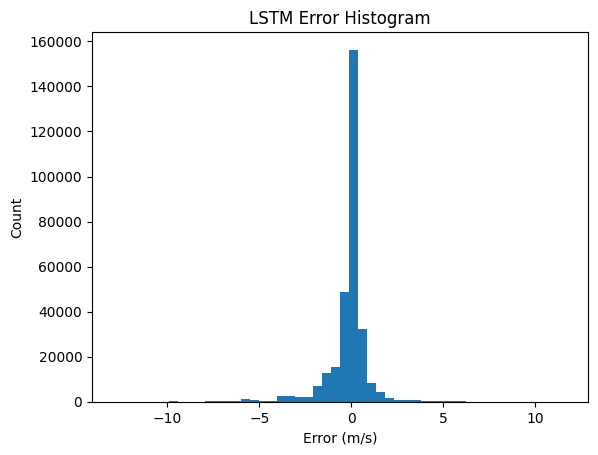

9481/9481 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


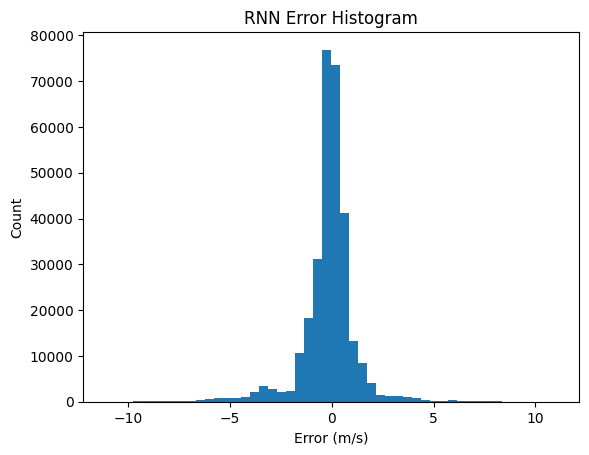

9481/9481 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step


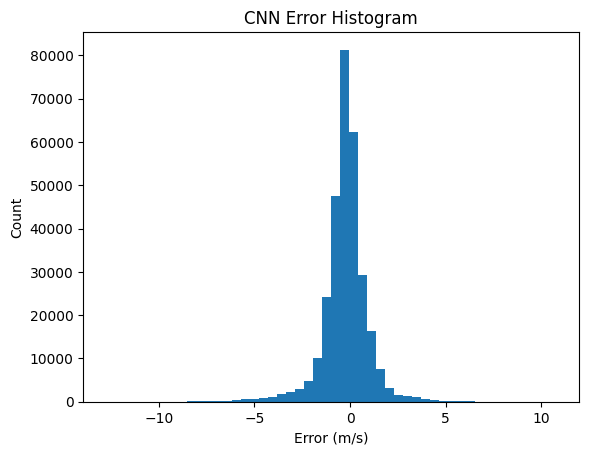

9481/9481 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step


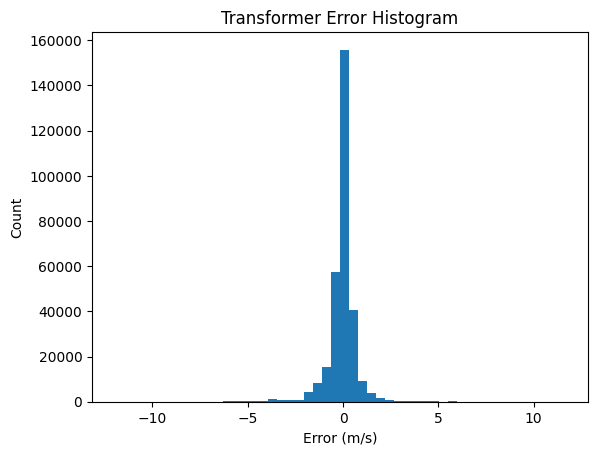

In [23]:

# ---------- 6. Plot error histograms ----------
for name in type_map.keys():
    model = tf.keras.models.load_model(os.path.join('models', f"{name.lower()}_model.keras"))
    y_pred = model.predict(test_ds).flatten()
    y_true = np.concatenate([y for _, y in test_ds], axis=0)
    errors = y_true - y_pred
    plt.figure()
    plt.hist(errors, bins=50)
    plt.title(f"{name} Error Histogram")
    plt.xlabel('Error (m/s)')
    plt.ylabel('Count')
    plt.show()


In [1]:
models = ['LSTM','Transformer','RNN','CNN']
mae    = [0.7693, 0.8859, 0.9795, 1.1556]
rmse   = [1.3526, 1.5258, 1.5642, 1.6403]

plt.figure()
x = range(len(models))
plt.bar(x, mae, width=0.4, label='MAE')
plt.bar([i+0.4 for i in x], rmse, width=0.4, label='RMSE')
plt.xticks([i+0.2 for i in x], models)
plt.ylabel('Error (m/s)')
plt.legend()
plt.show()

NameError: name 'plt' is not defined